In [1]:
import os
import math
import numpy as np
import pandas as pd
import sklearn.datasets
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from models import MLP
from data import load_2d_sample, load_gaussian_sample

In [2]:
# Perform rectified flow with model, given a prior sample (noise)
def rectified_flow(
    v_model, 
    prior_sample, 
    num_steps, 
):
    batch_size = prior_sample.shape[0]
    
    step_size = 1 / num_steps
    
    ### iterate through steps to refine output
    
    prior_cache = []
    prior_at_t = prior_sample
    prior_cache.append(prior_at_t)
    for t in np.linspace(0, 1, num_steps, endpoint = False):
        t_embedding = torch.ones((batch_size, 1)).cuda() * t
        v = v_model(prior_at_t, t_embedding)
        prior_at_t = prior_at_t + v * step_size
        prior_cache.append(prior_at_t)
        
    prior_cache = torch.stack(prior_cache, dim = 0)
    
    return prior_cache

def rf_train_one_step(
    v_model, 
    v_model_opt, 
    data_sample, prior_sample, 
):
    # sample shape: (batch, ...)
    
    assert data_sample.shape == prior_sample.shape
    
    v_model_opt.zero_grad()
    
    ### Training velocity model
    
    batch_size = data_sample.shape[0]
    
    t_shape = [batch_size if ii == 0 else 1 for ii in range(len(data_sample.shape))]
    
    t = torch.rand(*t_shape).cuda() # randomize time between [0, 1]
    
    mixed = t * data_sample + (1 - t) * prior_sample # t * X_1 + (1-t) * X_0 
    
    t_embeddings = t.reshape(batch_size, -1) # time embedding
    
    pred = v_model(mixed, t_embeddings)
    
    diff = data_sample - (prior_sample + pred)
    loss = torch.square(diff).mean()
    
    loss.backward()
    v_model_opt.step()

    v_model_opt.zero_grad()
    
    return loss.detach().cpu().numpy().item()

In [3]:
### Hyperparameters

# epochs = 10_000
epochs = 40_000

batch_size = 2048

lr = 1e-3

### Data

data_name = "swiss_roll"
prior_name = "gaussian"

### Initialize model

v_model = MLP(2, 1, 64, 4, step_size = None)

v_model.cuda()

v_model_opt = optim.Adam(v_model.parameters(), lr=lr)

### Initiate training

pbar = tqdm(total = epochs, position=0, leave=True)

history = []
model_cache = []

train_log = {"loss": np.nan}

for epoch in range(epochs):
    
    ### Sample data
    
    prior_sample = load_2d_sample(batch_size, name = prior_name).cuda()
    data_sample = load_2d_sample(batch_size, name = data_name).cuda()

    loss = rf_train_one_step(
        v_model, 
        v_model_opt, 
        data_sample, prior_sample, 
    )
    train_log = {"loss": loss}
    history.append(train_log)
    pbar.set_postfix(train_log)
        
    model_cache.append(v_model)
    
    pbar.update(1)

  0%|          | 0/40000 [00:00<?, ?it/s]

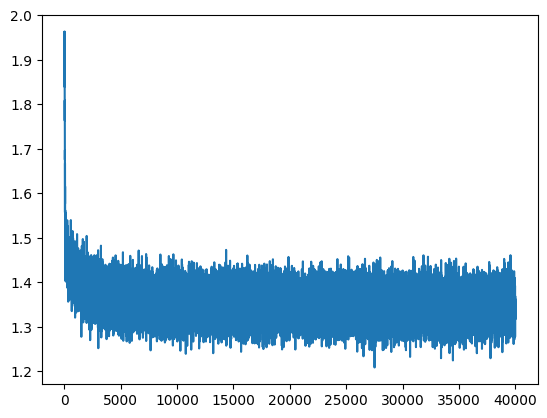

In [4]:
history_df = pd.DataFrame(history)

plt.plot(history_df["loss"])
plt.show()

In [5]:
### Hyperparameters for evaluation

num_steps = 10000

viz_batch_size = 1024
num_batch = 1

### Sample prior & perform flow

cache = []

for ii in tqdm(range(num_batch)):
    prior_sample = load_2d_sample(viz_batch_size, name = prior_name).cuda()
    
    flow_sample = rectified_flow(v_model, prior_sample, num_steps).detach().cpu().numpy()
    
    cache.append(flow_sample)
    
cache = np.concatenate(cache, axis = 1)

  0%|          | 0/1 [00:00<?, ?it/s]

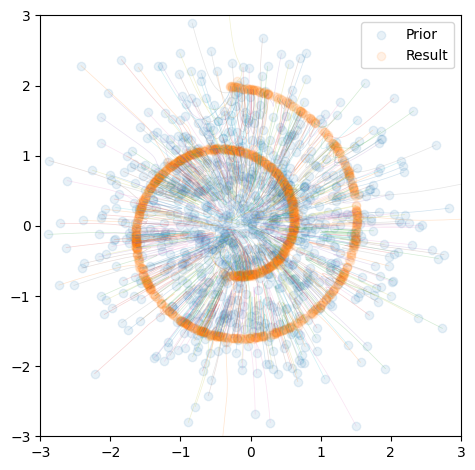

In [6]:
### Hyperparameters for plotting

num_viz_path = 1024

line_alpha = 0.2
scatter_alpha = 0.1

linewidth = 0.5

plot_dir = "plots"

### Plotting

for ii in np.random.choice(cache.shape[1], num_viz_path, replace = False):
    traj = cache[:, ii]
    plt.plot(traj[:, 0], traj[:, 1], linewidth = linewidth, alpha = line_alpha)

plt.scatter(cache[0, :, 0], cache[0, :, 1], alpha = scatter_alpha, label = "Prior")
plt.scatter(cache[-1, :, 0], cache[-1, :, 1], alpha = scatter_alpha, label = "Result")

plt.legend()

plt.axis('scaled')

plt.xlim([-3, 3])
plt.ylim([-3, 3])

plt.tight_layout()

plt.savefig(os.path.join(plot_dir, "RF_traj_{}_{}".format(prior_name, data_name)), dpi = 200, bbox_inches='tight', pad_inches=0)

plt.show()

In [7]:
diff = cache[1:] - cache[:-1]
distance = np.sqrt(np.square(diff).sum(axis = -1))
traj_distance = distance.sum(axis = 0)

print("Mean distance of trajectory:", traj_distance.mean())

Mean distance of trajectory: 0.8512348
